In [1]:
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
import os
# os.environ["JAX_LOG_COMPILES"] = "True"
from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif
from desc.utils import flatten_list

#from ..utils import cross, dot, safediv, safenorm
#from desc.compute.utils import cross
#from desc.compute.utils import dot

from desc.optimize import lsqtr, lsq_auglag

from scipy.optimize import NonlinearConstraint 

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, 
                                  ToroidalMagneticField,
                                  field_line_integrate)

import time

import numpy as np
from numpy.linalg import eig

from scipy.linalg import null_space
from numpy import ndarray


from desc.derivatives import Derivative

# Import my own functions
from desc.fns_simp import (#data_eval, 
                           #_compute_magnetic_field_from_Current,
                           plot_figure,
                           plot_figure2,
                           #plot_xy,
                           #surf_int
                          )

DESC version 0.12.3+553.gcb761a802.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64

Using device: NVIDIA A100-PCIE-40GB (id=0), with 40.00 GB available memory

In [3]:
#from desc.continuation import solve_continuation_automatic

from desc.objectives import (
    #AspectRatio,
    #FixBoundaryR,
    #FixBoundaryZ,
    #FixCurrent,
    #FixPressure,
    #FixPsi,
    #ForceBalance,
    ObjectiveFunction,
    #QuasisymmetryTwoTerm,
    #RotationalTransform,
    FixParameters, 
    ShareParameters,
    QuadraticFlux, 
    SurfaceCurrentRegularization, 
    bRegularization_fd,
    CoilThicknessRegularization,
    PlasmaVesselDistance,
    MeanCurvature,
    PrincipalCurvature,
)
from desc.optimize import Optimizer

In [4]:
# Plasma surfaces
eqname_QA = "/home/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eq_QA = desc.io.load(eqname_QA)[4]

eqname_QH = "/home/fcastro/LMStell/regcoil/rogerio/input.QH_final_output.h5" #vacuum equilibrium
eq_QH = desc.io.load(eqname_QH)[4]

In [5]:
#G_QA = eq_QA.compute("G")["G"][-1] / mu_0 * 2*np.pi
G_QH = eq_QH.compute("G")["G"][-1] / mu_0 * 2*np.pi

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

In [6]:
eq = eq_QH

#surf_name = "/home/fcastro/DESC/docs/notebooks/R_Opt_old/opt7/surf_opt.h5"
surf_name = "/home/fcastro/DESC/docs/notebooks/R_Opt/opt3/stell2/0p5/surf_opt.h5"
surf = load(surf_name)

In [7]:
surf1 = surf

# Generate a Surface Current field for RQH
surf2 = surf
#surf2.G = G_QH

#surf2.change_resolution(M = 10,N = 10)
#surf2.change_Phi_resolution(M = 12,N = 12)

In [8]:
# Find B on plasma surface
egrid = LinearGrid(M = 100, N = 100)

coords = eq.compute(["R", "phi", "Z"], grid = egrid)

n_rho = eq.compute("n_rho", grid = egrid)["n_rho"]

#B = coords["B"]
coords = np.vstack([coords["R"], coords["phi"], coords["Z"]]).T

# surface_current_field.compute_magnetic_field actually computes the normal field only
#B_from_surf = surf2.compute_magnetic_field(coords,)# grid=egrid)

# Plot B on the plasma surface
#mag_B = jnp.sqrt(dot(B_from_surf,B_from_surf))

#Bn = abs(dot(B_from_surf,n_rho))*mag_B**(-1) 

#plot_figure(Bn,egrid,''r'$\frac{|\mathbf{B} \cdot \mathbf{n}|}{|\mathbf{B}|}$')
#plot_figure(mag_B,egrid,''r'$|\mathbf{B}|$ (T)')

/home/fcastro/DESC/desc/transform.py:70: UserWarning: 

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

/home/fcastro/DESC/desc/transform.py:70: UserWarning: 

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

/home/fcastro/DESC/desc/transform.py:70: UserWarning: 

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

/home/fcastro/DESC/desc/transform.py:70: UserWarning: 

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

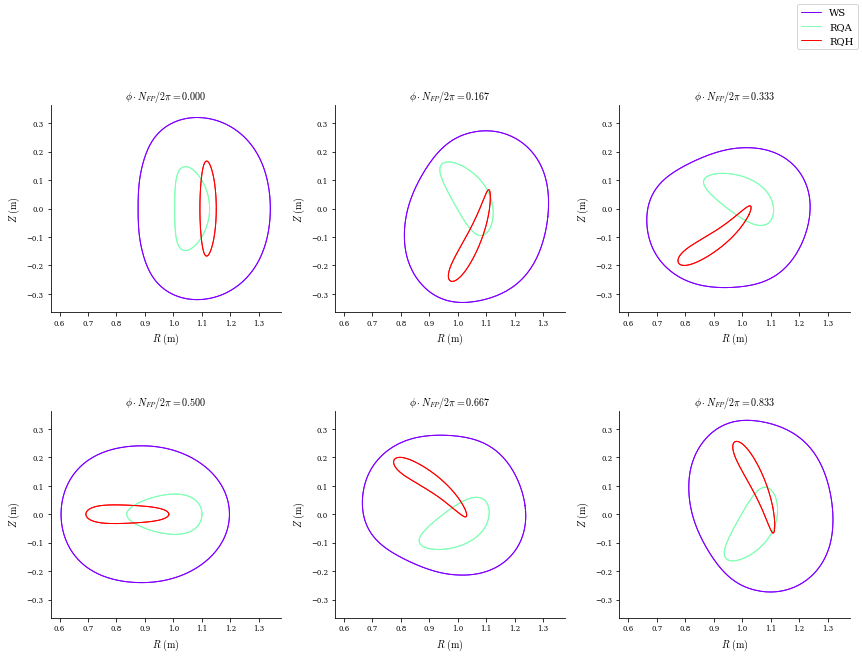

In [9]:
plot_comparison([surf1,eq_QA,eq_QH],
                labels=["WS","RQA","RQH"],
                theta=0,rho=np.array(1.0)
               )

In [10]:
# look at Phi and Bn
denser_source_grid = LinearGrid(M=60,N=60,
                                NFP=eq_QH.NFP
                               )

#plot_2d(eq_QH,"B*n",field=surf2, field_grid=denser_source_grid)
#plt.title("Eq 2 Bn error from surf2")

#plot_2d(surf2, "K")
#plt.title("K surf2")

In [11]:
## setup opt problem
# use QuadraticFlux as eq's are fixed and want fields to change
# use ShareParameters to keep surface geoms constant equal to eachother as they vary with surface current to reduce Bn
# first, keep surfs fixed too and just get regcoil-like solutions for each

In [12]:
# Grids
Megrid = 10
Negrid = 10

Msgrid = 25
Nsgrid = 15

egrid = LinearGrid(M=Megrid,N=Negrid,
                   NFP=eq.NFP,
                   sym=False)

sgrid = LinearGrid(M=Msgrid,N=Nsgrid,
                   NFP=eq.NFP,
                   sym=False) 

In [13]:
## setup opt problem
# use QuadraticFlux as eq's are fixed and want fields to change
# use ShareParameters to keep surface geoms constant equal
# to eachother as they vary with surface current to reduce Bn

In [14]:
flux_QA = QuadraticFlux(eq_QA,
                        surf1,
                        field_grid=sgrid,
                        eval_grid=egrid,
                        vacuum=True,
                        weight = 1e0,
                        name="Bn error  eq_QA")

flux_QH = QuadraticFlux(eq_QH,
                        surf2,
                        field_grid=sgrid,
                        eval_grid=egrid,
                        vacuum=True,
                        weight = 1e0,
                        name="Bn error  eq_QH")

In [15]:
# Distance target
min_QA = 0.07
max_QA = 0.3

min_QH = 0.07
max_QH = 0.1#1#0.28

# Distance to veseel penalization
obj_dist_QA = PlasmaVesselDistance(
    eq_QA,
    surf1,
    bounds=(min_QA,max_QA),
    #target = 0.15,
    plasma_grid=egrid,
    surface_grid=sgrid,
    eq_fixed=True,
    #softmin_alpha = 1e6,
    weight = 10,
    #use_signed_distance=True,
    name="distance error  RQA"
)

obj_dist_QH = PlasmaVesselDistance(
    eq_QH,
    surf2,
    #target = 0.15,
    bounds=(min_QH,max_QH),
    plasma_grid=egrid,
    surface_grid=sgrid,
    eq_fixed=True,
    #softmin_alpha = 1e6,
    #use_signed_distance=True,
    weight = 7e2,#20
    name="distance error  RQH"
)

In [16]:
surf_curr_reg_QA = SurfaceCurrentRegularization(
    surf1,
    #target=None,
    #bounds=None,
    weight=1e0,
    #normalize=True,
    #normalize_target=True,
    #loss_function=None,
    #deriv_mode="auto",
    source_grid=sgrid,
    name="surface-current-regularization QA",
    )

surf_curr_reg_QH = SurfaceCurrentRegularization(
    surf2,
    #target=None,
    #bounds=None,
    weight=1e0,
    #normalize=True,
    #normalize_target=True,
    #loss_function=None,
    #deriv_mode="auto",
    source_grid=sgrid,
    name="surface-current-regularization QA",
    )

In [17]:
mean_curv = -0.3
min_mean_curv = 0#-0.5
max_mean_curv = -0.15

obj_mean_curv = MeanCurvature(
    surf2,
    target = 0,
    #bounds = (-1,1),
    weight = 1e-2,
    normalize = True,
    normalize_target = True,
    deriv_mode = "auto",
    grid = sgrid,
    name = "Mean curvature",
)

In [18]:
obj_prin_curv = PrincipalCurvature(surf2,
        target = 0,
        #bounds=(-15,-10),
        weight=1e1,
        #normalize=True,
        #normalize_target=True,
        #loss_function=None,
        #deriv_mode="auto",
        grid=sgrid,
        name="principal-curvature",
        #jac_chunk_size=None,
    )

In [19]:
Jmax = 5e7 # max current density 50 MA/m2
tmax = 1.5e-1 # max thickness desired for coils: 10 cm

obj_thickness_QA = bRegularization_fd(surf1,
                                               #target=None,
                                               bounds = (0,Jmax*tmax),
                                               weight = 2e-6,
                                               #normalize=True,
                                               #normalize_target=True,
                                               #loss_function=None,
                                               deriv_mode="auto",
                                               source_grid = sgrid,
                                               name = "Coil Thickness Regularization: QA",
                                              )

# 1e-1 for bs
#1e10 for d_bs
obj_thickness_QH = bRegularization_fd(surf2,
                                               target=0,
                                               #bounds = (0,Jmax*tmax),
                                               weight = 6e-2,#6e-1,
                                               #normalize=True,
                                               #normalize_target=True,
                                               #loss_function=None,
                                               deriv_mode="auto",
                                               source_grid = sgrid,
                                               name = "Coil Thickness Regularization: QH",
                                              )

In [20]:
obj = ObjectiveFunction((#flux_QA,
                         flux_QH,
                         #obj_dist_QA,
                         #obj_dist_QH,
                         #obj_mean_curv,
                         #obj_prin_curv,
                         #surf_curr_reg_QA,
                         #surf_curr_reg_QH,
                         #obj_thickness_QA,
                         obj_thickness_QH,
                         #obj_sigma_QH,
                        )
                       )
constraints = (
    #FixParameters(surf1,{"G":True,}),# fix the secular poloidal current
    FixParameters(surf2,{"G":True,
                         "R_lmn":True, 
                         "Z_lmn":True,
                         }
                 ),# fix the secular poloidal current
    # make the 2 surfaces have the same geometry, dont need bc geom is fixed here
    #ShareParameters([surf1,surf2],params={"R_lmn":True, "Z_lmn":True}), 
)

In [21]:
# Choose the optimizer
opt = Optimizer("lsq-exact")

In [22]:
surf2.I

5326363.278365475

In [23]:
#surf2.I = 0

In [24]:
#surf2.I

In [25]:
# Run optimization
res,_ = opt.optimize(surf2, 
                                 objective=obj, 
                                 constraints=constraints,
                                 verbose=3,
                                 maxiter=60,
                                ftol=0,
                                gtol=0,
                                xtol=0,
                                 #options={"initial_trust_radius":np.inf}
                      )

surf2 = res[0]

Building objective: Bn error  eq_QH

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 1.43 sec

Building objective: Coil Thickness Regularization: QH

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 252 ms

Timer: Objective build = 2.16 sec

Building objective: fixed parameters

Timer: Objective build = 279 ms

Timer: Linear constraint projection build = 1.18 sec

Number of parameters: 313

Number of objectives: 2022

Timer: Initializing the optimization = 3.70 sec


Starting optimization

Using method: lsq-exact

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   

       0              1          4.100e+00                                    1.243e+01   

       1              3          1.613e+00      2.488e+00      9.329e+02      5.724e+00   

       2              5          1.496e+00      1.172e-01      1.202e+03      5.866e+00   

       3              6          1.225e+00      2.701e-01      7.449e+02      9.190e-01   

       4              7          1.167e+00      5.845e-02      3.991e+02      8.527e-01   

       5              9          1.149e+00      1.830e-02      9.491e+01      7.302e-01   

       6             10          1.138e+00      1.019e-02      8.081e+01      7.507e-01   

       7             11          1.131e+00      7.566e-03      6.859e+01      7.405e-01   

       8             12          1.124e+00      7.348e-03      1.005e+02      7.186e-01   

       9             13          1.117e+00      6.209e-03      8.268e+01      7.327e-01   

      10             14          1.111e+00      6.756e-03      1.012e+02      6.904e-01   

      11             15          1.105e+00      5.516e-03      8.660e+01      7.021e-01   

      12             16          1.099e+00      6.100e-03      1.005e+02      6.636e-01   

      13             17          1.094e+00      5.011e-03      8.974e+01      6.725e-01   

      14             18          1.088e+00      5.554e-03      1.005e+02      6.390e-01   

      15             19          1.084e+00      4.601e-03      9.196e+01      6.445e-01   

      16             20          1.079e+00      5.069e-03      1.004e+02      6.167e-01   

      17             21          1.074e+00      4.264e-03      9.349e+01      6.179e-01   

      18             22          1.070e+00      4.540e-03      3.425e+01      5.398e-01   

      19             23          1.067e+00      3.363e-03      4.140e+01      5.040e-01   

      20             24          1.063e+00      3.225e-03      3.648e+01      4.979e-01   

      21             25          1.060e+00      2.998e-03      4.365e+01      4.809e-01   

      22             26          1.057e+00      2.911e-03      4.202e+01      4.856e-01   

      23             27          1.055e+00      2.789e-03      4.790e+01      4.654e-01   

      24             28          1.052e+00      2.776e-03      4.455e+01      4.751e-01   

      25             29          1.049e+00      2.602e-03      4.973e+01      4.528e-01   

      26             30          1.047e+00      2.674e-03      4.634e+01      4.660e-01   

      27             31          1.044e+00      2.421e-03      5.091e+01      4.422e-01   

      28             32          1.042e+00      2.584e-03      4.790e+01      4.584e-01   

      29             33          1.039e+00      2.249e-03      5.194e+01      4.328e-01   

      30             34          1.037e+00      2.504e-03      4.934e+01      4.520e-01   

      31             35          1.035e+00      2.090e-03      5.294e+01      4.244e-01   

      32             36          1.032e+00      2.429e-03      5.070e+01      4.464e-01   

      33             37          1.030e+00      1.946e-03      5.390e+01      4.167e-01   

      34             38          1.028e+00      2.358e-03      5.198e+01      4.415e-01   

      35             39          1.026e+00      1.815e-03      5.482e+01      4.095e-01   

      36             40          1.024e+00      2.289e-03      5.319e+01      4.371e-01   

      37             41          1.022e+00      1.696e-03      5.570e+01      4.027e-01   

      38             42          1.020e+00      2.220e-03      5.431e+01      4.333e-01   

      39             43          1.018e+00      1.589e-03      5.653e+01      3.963e-01   

      40             44          1.016e+00      2.153e-03      5.535e+01      4.298e-01   

      41             45          1.015e+00      1.492e-03      5.730e+01      3.923e-01   

      42             46          1.013e+00      2.086e-03      5.631e+01      4.268e-01   

      43             47          1.011e+00      1.403e-03      5.803e+01      3.893e-01   

      44             48          1.009e+00      2.021e-03      5.720e+01      4.240e-01   

      45             49          1.008e+00      1.322e-03      5.871e+01      3.863e-01   

      46             50          1.006e+00      1.460e-03      1.421e+01      3.893e-01   

      47             51          1.005e+00      1.272e-03      2.053e+01      3.951e-01   

      48             52          1.004e+00      1.181e-03      1.440e+01      3.875e-01   

      49             53          1.003e+00      1.238e-03      1.316e+01      3.948e-01   

      50             54          1.001e+00      1.948e-03      2.262e+01      3.803e-01   

      51             55          9.993e-01      1.522e-03      3.946e+01      3.882e-01   

      52             56          9.982e-01      1.082e-03      5.039e+01      3.771e-01   

      53             57          9.968e-01      1.442e-03      1.314e+01      3.751e-01   

      54             58          9.956e-01      1.152e-03      2.000e+01      3.799e-01   

      55             59          9.946e-01      1.041e-03      1.549e+01      3.770e-01   

      56             60          9.935e-01      1.123e-03      1.498e+01      3.800e-01   

      57             61          9.925e-01      1.013e-03      1.488e+01      3.746e-01   

      58             62          9.914e-01      1.098e-03      1.485e+01      3.776e-01   

      59             63          9.904e-01      9.809e-04      1.504e+01      3.717e-01   

      60             64          9.893e-01      1.073e-03      1.517e+01      3.746e-01   

         Current function value: 9.893e-01

         Total delta_x: 6.555e+02

         Iterations: 60

         Function evaluations: 64

         Jacobian evaluations: 61

Timer: Solution time = 2.56 min

Timer: Avg time per step = 2.52 sec

                                                                 Start  -->   End

Total (sum of squares):                                      4.100e+00  -->   9.893e-01, 

Maximum absolute Boundary normal field error:                8.254e-03  -->   5.915e-03 (T m^2)

Minimum absolute Boundary normal field error:                1.269e-16  -->   1.705e-16 (T m^2)

Average absolute Boundary normal field error:                1.394e-04  -->   7.027e-04 (T m^2)

Maximum absolute Boundary normal field error:                1.448e-01  -->   1.038e-01 (normalized)

Minimum absolute Boundary normal field error:                2.227e-15  -->   2.992e-15 (normalized)

Average absolute Boundary normal field error:                2.447e-03  -->   1.233e-02 (normalized)

Maximum absolute Sigma Regularization:                       4.962e+00  -->   1.313e+00 

Minimum absolute Sigma Regularization:                       6.166e-13  -->   9.546e-14 

Average absolute Sigma Regularization:                       9.718e-01  -->   4.697e-01 

Maximum absolute Sigma Regularization:                       4.962e+00  -->   1.313e+00 (normalized)

Minimum absolute Sigma Regularization:                       6.166e-13  -->   9.546e-14 (normalized)

Average absolute Sigma Regularization:                       9.718e-01  -->   4.697e-01 (normalized)

Fixed parameters error:                                      0.000e+00  -->   9.313e-10 (~)

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

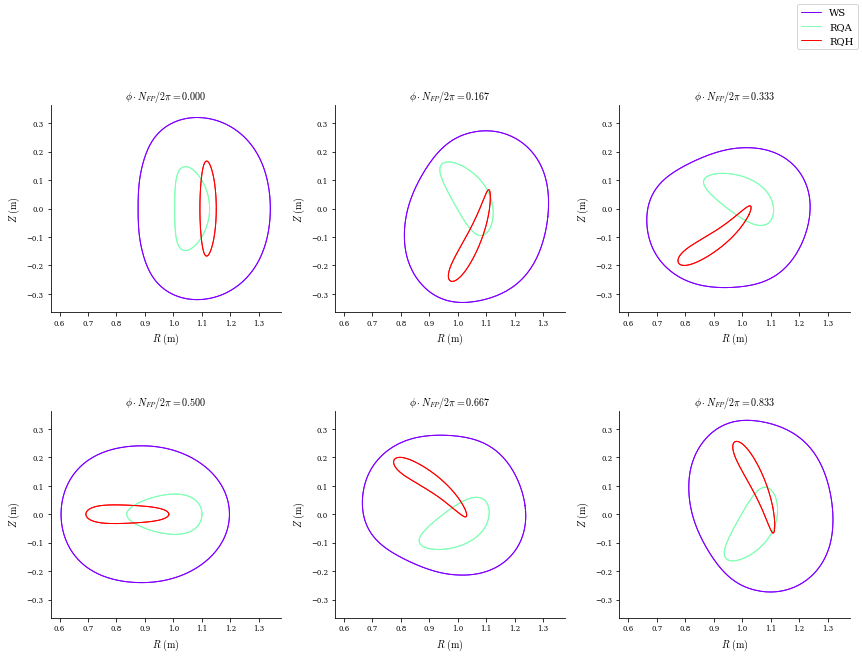

In [26]:
plot_comparison([surf2,
                 eq_QA,
                 eq_QH
                ],
                labels=["WS","RQA","RQH"],
                theta=0,rho=np.array(1.0)
               )

In [27]:
surf2.I

5352733.202297515

In [28]:
#plot_comparison([surf,surf2],
#                labels=["OWS","NWS"],
#                theta=0,rho=np.array(1.0)
#               )

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Text(0.5, 1.0, 'K surf2')

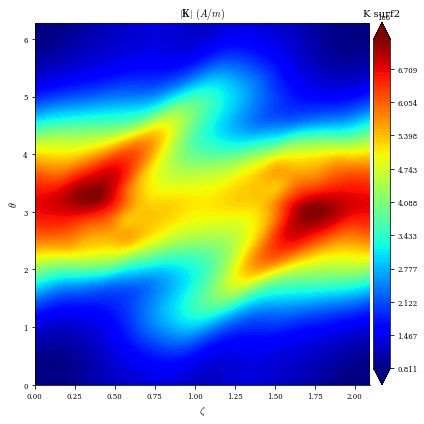

In [29]:
# look at Phi and Bn
denser_source_grid = LinearGrid(M=60,N=60,
                                NFP=eq_QH.NFP
                               )
#plot_2d(eq_QA,"B*n",field=surf1, field_grid=denser_source_grid)
#plt.title("Eq 1 Bn error from surf1")

#plot_2d(surf1, "K")
#plt.title("K surf1")

#plot_2d(eq_QH,"B*n",field=surf2, field_grid=denser_source_grid)
#plt.title("Eq 2 Bn error from surf2")

plot_2d(surf2, "K")
plt.title("K surf2")

In [30]:
#b_QA = surf1.compute("b_s",grid = denser_source_grid)["b_s"]

#plot_figure2(b_QA,
#            denser_source_grid,
#            ''r'$b_{QA}$ '
#           )

/home/fcastro/DESC/desc/transform.py:70: UserWarning: 

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

/home/fcastro/DESC/desc/transform.py:70: UserWarning: 

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

/home/fcastro/DESC/desc/transform.py:70: UserWarning: 

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

/home/fcastro/DESC/desc/transform.py:70: UserWarning: 

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

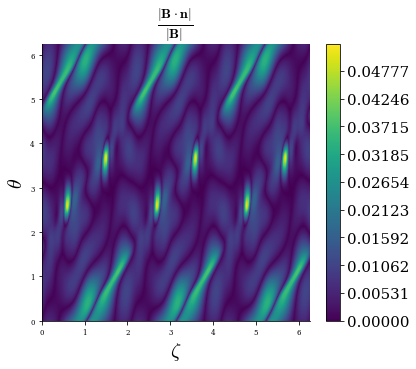

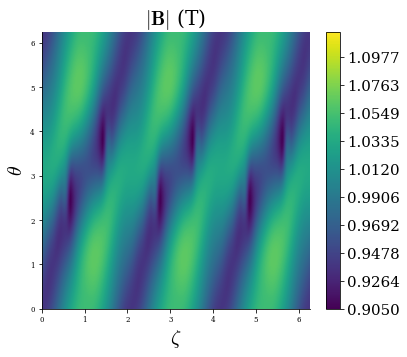

In [31]:
# Find B on plasma surface
egrid = LinearGrid(M = 100, N = 100)

coords = eq.compute(["R", "phi", "Z"], grid = egrid)

n_rho = eq.compute("n_rho", grid = egrid)["n_rho"]

#B = coords["B"]
coords = np.vstack([coords["R"], coords["phi"], coords["Z"]]).T

# surface_current_field.compute_magnetic_field actually computes the normal field only
B_from_surf = surf2.compute_magnetic_field(coords,)# grid=egrid)

# Plot B on the plasma surface
mag_B = jnp.sqrt(dot(B_from_surf,B_from_surf))

Bn = abs(dot(B_from_surf,n_rho))*mag_B**(-1) 

plot_figure(Bn, egrid, ''r'$\frac{|\mathbf{B} \cdot \mathbf{n}|}{|\mathbf{B}|}$')
plot_figure(mag_B, egrid, ''r'$|\mathbf{B}|$ (T)')

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

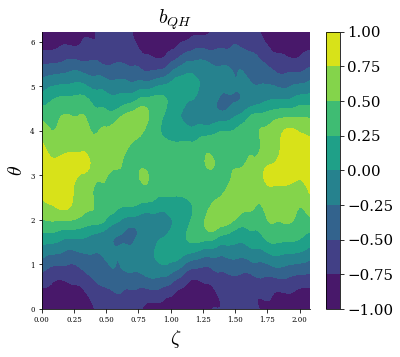

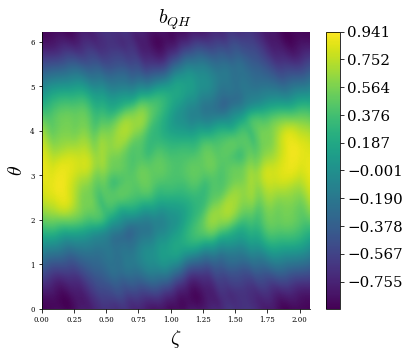

In [32]:
b_QH = surf2.compute("b_s",grid = denser_source_grid)["b_s"]

plot_figure2(b_QH,
            denser_source_grid,
            ''r'$b_{QH}$ '
           )

plot_figure(b_QH,
            denser_source_grid,
            ''r'$b_{QH}$ '
           )

In [33]:
#surf2.save("surf_opt_3.h5")